In [1]:
def collect_and_download(derivative, pipeline, strategy, out_dir, diagnosis):
    import os
    import urllib.request as request

    # Init variables
    mean_fd_thresh = 0.2
    s3_prefix = 'https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative'
    s3_pheno_path = '/'.join([s3_prefix, 'Phenotypic_V1_0b_preprocessed1.csv'])

    derivative = derivative.lower()
    pipeline = pipeline.lower()
    strategy = strategy.lower()

    # Check derivative for extension
    if 'roi' in derivative:
        extension = '.1D'
    else:
        extension = '.nii.gz'

    if not os.path.exists(out_dir):
        print('Could not find {0}, creating now...'.format(out_dir))
        os.makedirs(out_dir)

    s3_pheno_file = request.urlopen(s3_pheno_path)
    pheno_list = s3_pheno_file.readlines()


    header = pheno_list[0].decode().split(',')
    try:
        site_idx = header.index('SITE_ID')
        file_idx = header.index('FILE_ID')
        age_idx = header.index('AGE_AT_SCAN')
        sex_idx = header.index('SEX')
        dx_idx = header.index('DX_GROUP')
        mean_fd_idx = header.index('func_mean_fd')
    except Exception as exc:
        err_msg = 'Unable to extract header information from the pheno file...'
        raise Exception(err_msg)
    s3_paths = []
    for pheno_row in pheno_list[1:]:
        cs_row = pheno_row.decode().split(',')

        try:
            row_file_id = cs_row[file_idx]
            row_site = cs_row[site_idx]
            row_age = float(cs_row[age_idx])
            row_sex = cs_row[sex_idx]
            row_dx = cs_row[dx_idx]
            row_mean_fd = float(cs_row[mean_fd_idx])
        except Exception as e:
            continue

        if row_file_id == 'no_filename':
            continue
        if row_mean_fd >= mean_fd_thresh:
            continue

        if (diagnosis == 'asd' and row_dx != '1') or (diagnosis == 'tdc' and row_dx != '2'):
           continue

        filename = row_file_id + '_' + derivative + extension
        s3_path = '/'.join([s3_prefix, 'Outputs', pipeline, strategy, derivative, filename])
        s3_paths.append(s3_path)

    total_num_files = len(s3_paths)
    for path_idx, s3_path in enumerate(s3_paths):
        rel_path = s3_path.lstrip(s3_prefix)
        download_file = os.path.join(out_dir,rel_path)
        download_dir = os.path.dirname(download_file)
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)
        try:
            if not os.path.exists(download_file):
                print('Retrieving: {0}'.format(download_file))
                request.urlretrieve(s3_path, download_file)
                print('{0:.3f}% percent complete'.format(100*(float(path_idx+1)/total_num_files)))
            else:
                print('File {0} already exists, skipping...'.format(download_file))
        except Exception as exc:
            print('There was a problem downloading {0}.\n Check input arguments and try again.'.format(s3_path))

    print('Done!')

In [2]:
# pipelines = ["ccs", "cpac", "dparsf", "niak"]
# strategies = ["filt_global", "filt_noglobal", "nofilt_global", "nofilt_noglobal"]
# derivatives = ["alff", "degree_binarize", "degree_weighted", "dual_regression", "eigenvector_binarize", "eigenvector_weighted", "falff", "func_mask", "func_mean", "func_preproc", "lfcd", "reho", "rois_aal", "rois_cc200", "rois_cc400", "rois_dosenbach160", "rois_ez", "rois_ho", "rois_tt", "vmhc"]
# extensions = ["1D", "nii.gz"]

# Variables to specify download settings (modify these values as needed)
desired_derivative = 'rois_cc200'  # Derivative of interest (e.g. 'reho')
desired_pipeline = 'cpac'     # Pipeline used to preprocess the data (e.g. 'cpac')
desired_strategy = 'filt_global'  # Noise-removal strategy used during preprocessing
download_data_dir = 'preprocessed_dataset_asd'  # Path to local folder to download files to
desired_diagnosis = 'asd'  # 'asd', 'tdc', or 'both' corresponding to the diagnosis of the participants for whom data should be downloaded

# Call the collect and download routine
collect_and_download(desired_derivative, desired_pipeline, desired_strategy, download_data_dir, desired_diagnosis)
download_data_dir = 'preprocessed_dataset_tdc'  # Path to local folder to download files to
desired_diagnosis = 'tdc'  # 'asd', 'tdc', or 'both' corresponding to the diagnosis of the participants for whom data should be downloaded
collect_and_download(desired_derivative, desired_pipeline, desired_strategy, download_data_dir, desired_diagnosis)

Could not find preprocessed_dataset_asd, creating now...
Retrieving: preprocessed_dataset_asd/Outputs/cpac/filt_global/rois_cc200/Pitt_0050004_rois_cc200.1D
0.245% percent complete
Retrieving: preprocessed_dataset_asd/Outputs/cpac/filt_global/rois_cc200/Pitt_0050005_rois_cc200.1D
0.490% percent complete
Retrieving: preprocessed_dataset_asd/Outputs/cpac/filt_global/rois_cc200/Pitt_0050006_rois_cc200.1D
0.735% percent complete
Retrieving: preprocessed_dataset_asd/Outputs/cpac/filt_global/rois_cc200/Pitt_0050007_rois_cc200.1D
0.980% percent complete
Retrieving: preprocessed_dataset_asd/Outputs/cpac/filt_global/rois_cc200/Pitt_0050008_rois_cc200.1D
1.225% percent complete
Retrieving: preprocessed_dataset_asd/Outputs/cpac/filt_global/rois_cc200/Pitt_0050009_rois_cc200.1D
1.471% percent complete
Retrieving: preprocessed_dataset_asd/Outputs/cpac/filt_global/rois_cc200/Pitt_0050010_rois_cc200.1D
1.716% percent complete
Retrieving: preprocessed_dataset_asd/Outputs/cpac/filt_global/rois_cc200/Pi

In [3]:
#!rm -rf dataset
!rm -rf sample_data

In [4]:
!mkdir dataset
!mkdir dataset/1
!mkdir dataset/0
!mv preprocessed_dataset_asd/Outputs/cpac/filt_global/rois_cc200/* dataset/1
!mv preprocessed_dataset_tdc/Outputs/cpac/filt_global/rois_cc200/* dataset/0
!rm -rf preprocessed_dataset_asd/ preprocessed_dataset_tdc/

In [5]:
# !zip -r "12" /content/1
# !zip -r "02" /content/0

In [6]:
import os
import numpy as np

dataset_path='dataset/'

data=[]
labels=[]
for class_name in os.listdir(dataset_path):
  class_path=os.path.join(dataset_path,class_name)
  if os.path.isdir(class_path):
    for file_name in os.listdir(class_path):
      file_path=os.path.join(class_path,file_name)
      if 'NYU' in file_path or 'SDSU' in file_path:
        data_file = np.loadtxt(file_path, comments='#')
        print(data_file.shape,file_path)
        #data_file = nib.load(file_path)
        #f_data=data_file.get_fdata()
        data.append(data_file)
        labels.append(int(class_name))
data_corr=np.array(data)
labels_corr=np.array(labels)

(176, 200) dataset/0/NYU_0051039_rois_cc200.1D
(176, 200) dataset/0/NYU_0051038_rois_cc200.1D
(176, 200) dataset/0/NYU_0051069_rois_cc200.1D
(176, 200) dataset/0/SDSU_0050195_rois_cc200.1D
(176, 200) dataset/0/NYU_0051059_rois_cc200.1D
(176, 200) dataset/0/SDSU_0050217_rois_cc200.1D
(176, 200) dataset/0/NYU_0051093_rois_cc200.1D
(176, 200) dataset/0/NYU_0051150_rois_cc200.1D
(176, 200) dataset/0/SDSU_0050199_rois_cc200.1D
(176, 200) dataset/0/NYU_0051116_rois_cc200.1D
(176, 200) dataset/0/NYU_0051148_rois_cc200.1D
(176, 200) dataset/0/NYU_0051050_rois_cc200.1D
(176, 200) dataset/0/NYU_0051057_rois_cc200.1D
(176, 200) dataset/0/NYU_0051154_rois_cc200.1D
(176, 200) dataset/0/NYU_0051046_rois_cc200.1D
(176, 200) dataset/0/NYU_0051056_rois_cc200.1D
(176, 200) dataset/0/NYU_0051045_rois_cc200.1D
(176, 200) dataset/0/NYU_0051074_rois_cc200.1D
(176, 200) dataset/0/NYU_0051156_rois_cc200.1D
(176, 200) dataset/0/NYU_0051048_rois_cc200.1D
(176, 200) dataset/0/NYU_0051080_rois_cc200.1D
(176, 200)

In [7]:
!pip install nilearn
import numpy as np
from nilearn.connectome import ConnectivityMeasure,sym_matrix_to_vec

# Initialize ConnectivityMeasure object
conn_est = ConnectivityMeasure(kind='correlation',discard_diagonal=True) # Connectivity Estimator

# List to store connectivity matrices for each subject
conn_matrices = []

# Compute connectivity matrices for each subject
for data_point in data_corr:
    # Compute connectivity matrix for the current subject
    conn_matrix = conn_est.fit_transform([data_point])[0]

    # Append the computed connectivity matrix to the list
    conn_matrices.append(conn_matrix)

# Print the connectivity matrix of the first subject as an example
print(conn_matrices[0])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 110.1 MB/s eta 0:00:00
[[ 1.         -0.31660117 -0.24015473 ...  0.14187227  0.02804109
  -0.37695863]
 [-0.31660117  1.          0.19112668 ...  0.06925342 -0.0877196
  -0.18810682]
 [-0.24015473  0.19112668  1.         ...  0.03863591  0.01896526
   0.06127912]
 ...
 [ 0.14187227  0.06925342  0.03863591 ...  1.          0.40034488
  -0.0124856 ]
 [ 0.02804109 -0.0877196   0.01896526 ...  0.40034488  1.
  -0.1320311 ]
 [-0.37695863 -0.18810682  0.06127912 ... -0.0124856  -0.1320311
   1.        ]]


In [8]:
  corr_sum_asd = np.zeros_like(conn_matrices[0])  # Initialize with zeros
corr_sum_tdc = np.zeros_like(conn_matrices[0])  # Initialize with zeros
print(corr_sum_asd)
num_asd =0
num_tdc =0
#print(len(labels))
for i in range(len(labels)):
    if labels[i] == 1:
        num_asd+=1
        #print(i)
        corr_sum_asd += conn_matrices[i]  # Add the connectivity matrix to corr_sum_asd
    else:
        num_tdc+=1
        corr_sum_tdc += conn_matrices[i]  # Add the connectivity matrix to corr_sum_tdc

print(num_asd)

avg_corr_asd = corr_sum_asd / num_asd  # Compute average for ASD group
avg_corr_tdc = corr_sum_tdc / num_tdc  # Compute average for TDC group
print(avg_corr_asd)
diff_corr_matrix=np.subtract(avg_corr_tdc,avg_corr_asd)
arr=sym_matrix_to_vec(diff_corr_matrix,discard_diagonal=True)
enum_arr = list(enumerate(arr))

# Sort the array based on values
sorted_arr = sorted(enum_arr, key=lambda x: x[1])

# Get the indices and values of the largest and smallest 1000 elements
largest_indices = [idx for idx, val in sorted_arr[-1000:]]

smallest_indices = [idx for idx, val in sorted_arr[:1000]]

combined_indices=smallest_indices+largest_indices
sorted_indices=np.sort(combined_indices)
print(sorted_indices)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
85
[[ 1.         -0.10673409 -0.04957689 ... -0.0169658  -0.06892433
  -0.04940669]
 [-0.10673409  1.          0.1898399  ... -0.03786567 -0.05485093
  -0.0043911 ]
 [-0.04957689  0.1898399   1.         ... -0.02285931  0.08407262
  -0.06412908]
 ...
 [-0.0169658  -0.03786567 -0.02285931 ...  1.          0.0591537
   0.02751312]
 [-0.06892433 -0.05485093  0.08407262 ...  0.0591537   1.
  -0.0566303 ]
 [-0.04940669 -0.0043911  -0.06412908 ...  0.02751312 -0.0566303
   1.        ]]
[   34    48    54 ... 19855 19875 19878]


In [9]:
print(conn_matrix.shape)

(200, 200)


<Axes: >

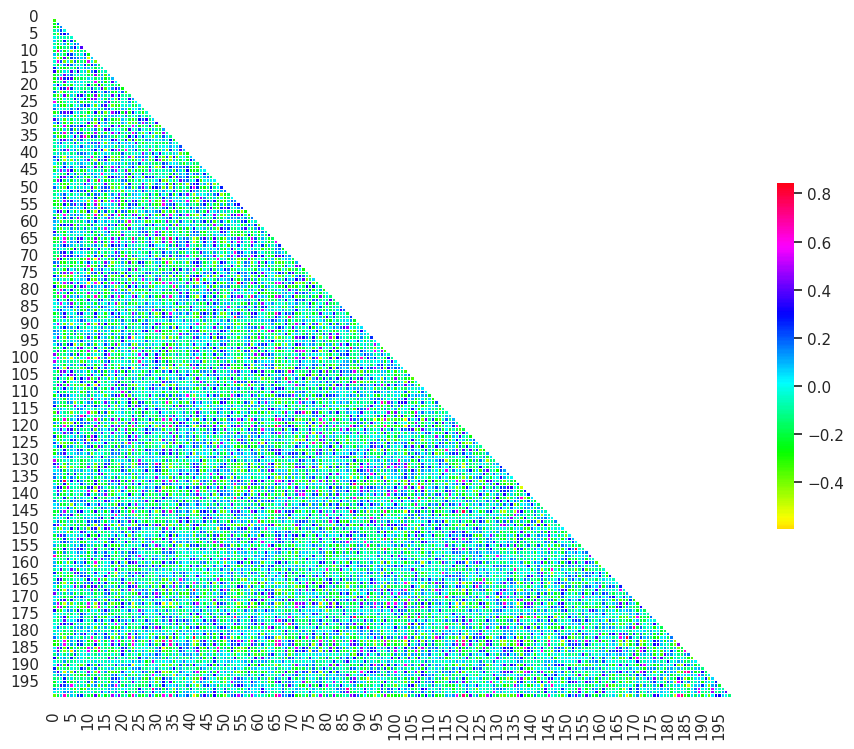

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = conn_matrices[0]
sns.set_theme(style="white")
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap='hsv', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [11]:
data=[]
for c_matrix in conn_matrices:
  data.append(sym_matrix_to_vec(c_matrix,discard_diagonal=True))
data=np.array(data)
labels=(np.array(labels))
print(data.shape)
print(labels.shape)

(204, 19900)
(204,)


In [12]:
def extract_reduced_data(input):
  res=[]
  for i in sorted_indices:
    res.append(input[i])
  return res

data_reduced=[]
for data_seg in data:
  data_reduced.append(extract_reduced_data(data_seg))
data_reduced=np.array(data_reduced)
print(data_reduced.shape)

(204, 2000)


In [13]:
data_reduced[0].shape

(2000,)

In [14]:
print(sorted_indices)

[   34    48    54 ... 19855 19875 19878]


In [15]:
from sklearn.model_selection import train_test_split
train_data,test_data,train_labels,test_labels=train_test_split(data_reduced,labels,test_size=0.2,random_state=42)
train_labels

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0])

In [16]:
# import tensorflow as tf
# from tensorflow.keras import layers, models

# input_shape = (2000,)  # Assuming each input array has 2100 features

# # Define the ANN model
# model = models.Sequential()

# # Add the input layer
# model.add(layers.Input(shape=input_shape))

# # Add dense (fully connected) layers
# #model.add(layers.Dense(8000))
# # model.add(layers.LeakyReLU(alpha=0.2))
# # model.add(layers.Dense(13))
# # model.add(layers.LeakyReLU(alpha=0.2))
# model.add(layers.Dense(4))
# model.add(layers.LeakyReLU(alpha=0.2))

# # Output layer for binary classification
# model.add(layers.Dense(1, activation='sigmoid'))

# # Compile the model
# model.compile(optimizer='RMSprop',
#               loss='mean_squared_error',
#               metrics=['accuracy'])

# # Print model summary
# model.summary()
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = (2000, 1)  # Assuming each input array has 2100 features

# Reshape input to fit Conv1D
inputs = layers.Input(shape=input_shape)
reshape = layers.Reshape((2000, 1))(inputs)

# Define the CNN model
model = models.Sequential()

# Add Convolutional layers
model.add(layers.Conv1D(filters=32, kernel_size=3, input_shape=(2000, 1)))
model.add(layers.LeakyReLU(alpha=0.2))
model.add(layers.Dropout(0.5))

# Flatten the output of the convolutional layers
model.add(layers.Flatten())

# Add dense (fully connected) layers
model.add(layers.Dense(64))
model.add(layers.LeakyReLU(alpha=0.2))

# Output layer for binary classification
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='RMSprop',
              loss='mean_squared_error',
              metrics=['accuracy'])

# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 1998, 32)            │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 1998, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1998, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 63936)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       4,091,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,092,161 (15.61 MB)

 Trainable params: 4,092,161 (15.61 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data, train_labels, epochs=10, validation_data=(test_data, test_labels))
# Evaluate the model
test_loss, test_acc = model.evaluate(test_data, test_labels)
print('Test accuracy:', test_acc)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 459ms/step - accuracy: 0.4888 - loss: 0.3539 - val_accuracy: 0.5854 - val_loss: 0.1996
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7755 - loss: 0.1444 - val_accuracy: 0.4634 - val_loss: 0.4263
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7457 - loss: 0.1757 - val_accuracy: 0.8537 - val_loss: 0.1204
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9309 - loss: 0.0538 - val_accuracy: 0.5610 - val_loss: 0.4173
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7737 - loss: 0.1956 - val_accuracy: 0.6098 - val_loss: 0.2593
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8991 - loss: 0.0608 - val_accuracy: 0.8780 - val_loss: 0.1175
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9925 - loss: 0.0173 - val_accuracy: 0.8049 - val_loss: 0.1502
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9642 - loss: 0.0317 - val_accuracy: 0.8780 - val_loss: 0.1052
Epoch 

Accuracy


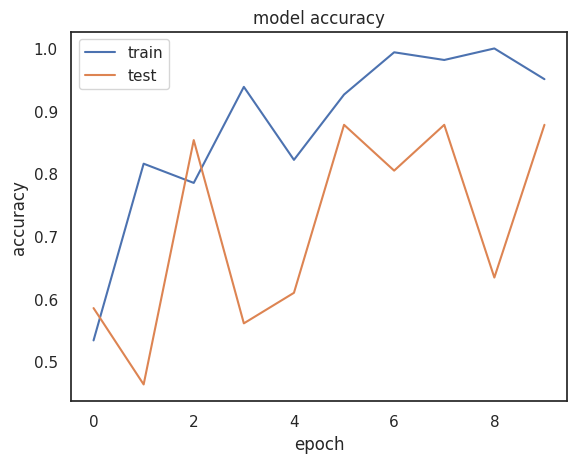

Loss


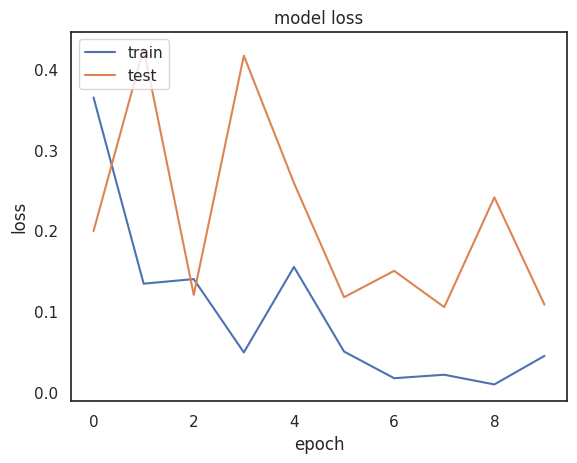

In [18]:
import matplotlib.pyplot as plt
# summarize history for accuracy
print("Accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()
# summarize history for loss
print("Loss")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [19]:
model.save('/content/cc200.keras')

In [20]:
!zip -r /content/model.zip /content/model

	zip warning: name not matched: /content/model

zip error: Nothing to do! (try: zip -r /content/model.zip . -i /content/model)


In [21]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [27]:
m=tf.keras.models.load_model('/content/cc200.keras')

In [25]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from google.colab import files

# Load the trained model
model = tf.keras.models.load_model('/content/cc200.keras')

# Define preprocessing function
def preprocess_data(file_path):
    """
    Preprocesses the input test data file for inference.
    Ensures the data matches the expected shape (2000, 1).
    """
    try:
        # Load the input data
        data = np.loadtxt(file_path)

        # Check if the total size is divisible by 2000
        if data.size % 2000 != 0:
            raise ValueError(f"Input data size {data.size} is not compatible with the model's expected shape (2000, 1).")

        # Reshape for Conv1D input
        num_samples = data.size // 2000
        data = data.reshape(num_samples, 2000, 1)

        return data
    except Exception as e:
        raise ValueError(f"Error during preprocessing: {e}")


# Define inference function
def predict(file_path):
    """
    Runs inference on the preprocessed data using the trained model.
    """
    # Preprocess the uploaded data
    data = preprocess_data(file_path)
    print(f"Data shape after preprocessing: {data.shape}")

    # Make predictions
    predictions = model.predict(data)
    return predictions

# Upload a file using Colab's file uploader
uploaded = files.upload()

# Run prediction on uploaded file
for file_name in uploaded.keys():
    print(f"Uploaded file: {file_name}")
    try:
        predictions = predict(file_name)
        print(f"Predictions: {predictions}")
    except Exception as e:
        print(f"Error during inference: {e}")


Saving CMU_b_0050657_rois_cc200.1D to CMU_b_0050657_rois_cc200.1D
Uploaded file: CMU_b_0050657_rois_cc200.1D
Error during inference: Error during preprocessing: Input data size 63200 is not compatible with the model's expected shape (2000, 1).


In [29]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.weights.h5")
print("Saved model to disk")

Saved model to disk


In [30]:
m.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 1998, 32)            │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 1998, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1998, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 63936)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       4,091,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,184,324 (31.22 MB)

 Trainable params: 4,092,161 (15.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,092,163 (15.61 MB)

In [31]:
import tensorflow as tf

# Load model architecture from JSON
with open("model.json", "r") as json_file:
    loaded_model_json = json_file.read()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)

# Load model weights from HDF5
loaded_model.load_weights("model.weights.h5")
print("Loaded model from disk")


Loaded model from disk


In [42]:
from google.colab import files
import numpy as np

# Upload the indices.txt file
uploaded = files.upload()

# Check if the file was uploaded
if "indices.txt" in uploaded:
    # Load the indices from the uploaded file
    indices = np.loadtxt("indices.txt")
    print(f"Loaded indices from the file: {indices}")
else:
    print("Please upload the indices.txt file!")


Saving indices.txt to indices.txt
Loaded indices from the file: [   34.    48.    54. ... 19855. 19875. 19878.]


In [49]:
import numpy as np
import tensorflow as tf
from nilearn.connectome import ConnectivityMeasure
import os

# Function to load indices.txt from the given path
def load_indices(file_path="/content/indices.txt"):
    if os.path.exists(file_path):
        indices = np.loadtxt(file_path)  # Load the indices as a numpy array
        print(f"Loaded indices from the file: {indices}")
        return indices
    else:
        print(f"File {file_path} does not exist!")
        return None

# Assuming labels, conn_matrices, and "indices.txt" are already loaded and available
def preprocess(path):
    res = []
    input_file = np.loadtxt(path)

    indices = load_indices()  # Load indices from the specified file path

    if indices is None:
        raise ValueError("Indices file not found or empty!")

    # Initialize ConnectivityMeasure object
    conn_est = ConnectivityMeasure(kind='correlation', discard_diagonal=True)  # Connectivity Estimator

    # Compute the connectivity matrix for the current subject
    conn_matrix = conn_est.fit_transform([input_file])[0]
    data = sym_matrix_to_vec(conn_matrix, discard_diagonal=True)  # Convert to vector
    print(conn_matrix)  # Print the connectivity matrix for verification
    print(data.shape)  # Print the shape of the resulting data vector

    # Extract values using indices and append to result list
    for i in indices:
        res.append(data[int(i)])  # Select values at specified indices

    print(res)  # Print the final extracted data
    return np.array(res)  # Return as numpy array to be used for predictions


# Model loading function
def load_model():
    with open("model.json", "r") as json_file:
        loaded_model_json = json_file.read()
    model = tf.keras.models.model_from_json(loaded_model_json)
    model.load_weights("model.weights.h5")
    print("Loaded model from disk")
    return model

# Predict using the loaded model
def predict(file_path, model):
    data = preprocess(file_path)  # Call the new preprocess method
    data = data.reshape(1, 2000, 1)  # Reshape to match the model's expected input shape (1, 2000, 1)
    print(f"Preprocessed data shape: {data.shape}")
    predictions = model.predict(data)
    return predictions

# Main script
if __name__ == "__main__":
    # Load the model
    model = load_model()

    # Specify the test file path (you should pass a file that matches your data)
    test_file = "/content/dataset/0/Caltech_0051479_rois_cc200.1D"  # Replace with your actual test file

    # Run predictions using the uploaded indices file
    try:
        result = predict(test_file, model)
        print("Prediction result:", result)

        # Interpretation of result: If result is greater than 0.5, classify as non-autistic (TDC)
        if result[0][0] > 0.5:
            print("Predicted as non-autistic (TDC)")
        else:
            print("Predicted as autistic (ASD)")

    except Exception as e:
        print("Error during inference:", e)


Loaded model from disk
Loaded indices from the file: [   34.    48.    54. ... 19855. 19875. 19878.]
[[ 1.          0.17167368  0.31711464 ... -0.06753885 -0.18923165
   0.01881775]
 [ 0.17167368  1.          0.44100955 ... -0.10456272 -0.0125744
   0.08659542]
 [ 0.31711464  0.44100955  1.         ... -0.08137933  0.0482029
  -0.00388144]
 ...
 [-0.06753885 -0.10456272 -0.08137933 ...  1.         -0.14289883
  -0.04546516]
 [-0.18923165 -0.0125744   0.0482029  ... -0.14289883  1.
  -0.02820776]
 [ 0.01881775  0.08659542 -0.00388144 ... -0.04546516 -0.02820776
   1.        ]]
(19900,)
[0.16315931824776594, 0.029974247763044012, -0.2074855810559157, -0.2620780349296073, -0.3927737938914323, 0.041096341115596124, -0.14001868638548337, 0.25810492655575823, -0.32539196479273247, -0.20391828061527256, -0.052219936312476706, -0.11842657608047293, 0.10938223333557567, -0.0335474539957041, 0.2785897829411816, 0.10660477686280281, 0.1785672119947005, 0.22248649918440636, -0.3283577846271855, -0